In [1]:
import itk
print(itk.__version__)

5.4.0


In [2]:
import itk
import matplotlib.pyplot as plt

# Chemins des fichiers d'image
fixed_filepath = 'Data/case6_gre1.nrrd'
moving_filepath = 'Data/case6_gre2.nrrd'
output_filepath = 'output_transformed_image.nrrd'

# Définir le type d'image
PixelType = itk.F
ImageType = itk.Image[PixelType, 3]

# Charger les images
fixed_image = itk.imread(fixed_filepath, PixelType)
moving_image = itk.imread(moving_filepath, PixelType)

# Définir le type de transformation
TransformType = itk.VersorRigid3DTransform[itk.D]
initial_transform = TransformType.New()

# Définir le type d'optimiseur et de métrique
optimizer = itk.RegularStepGradientDescentOptimizerv4.New()
optimizer.SetLearningRate(4)
optimizer.SetMinimumStepLength(0.001)
optimizer.SetNumberOfIterations(200)

metric = itk.MeanSquaresImageToImageMetricv4[ImageType, ImageType].New()

# Créer l'objet de registration
registration = itk.ImageRegistrationMethodv4[ImageType, ImageType].New(
    FixedImage=fixed_image,
    MovingImage=moving_image,
    Metric=metric,
    Optimizer=optimizer,
    InitialTransform=initial_transform
)

# Initialiser la transformation
TransformInitializerType = itk.CenteredTransformInitializer[
    TransformType,
    ImageType,
    ImageType
]
initializer = TransformInitializerType.New()

initializer.SetTransform(initial_transform)
initializer.SetFixedImage(fixed_image)
initializer.SetMovingImage(moving_image)

# Utiliser le centre de masse pour l'initialisation
initializer.MomentsOn()
initializer.InitializeTransform()

# Configurer la rotation (rotation par défaut = 0)
# Utiliser un vecteur pour définir l'axe de rotation et l'angle
#axis = itk.Vector[itk.D, 3]()
#axis[0] = 0.0
#axis[1] = 0.0
#axis[2] = 1.0
#angle = 0.0  # Angle en radians

# Appliquer la rotation à la transformation
#initial_transform.SetRotation(axis, angle)

# Exécuter la registration
try:
    registration.Update()
except Exception as e:
    print(f"Une erreur est survenue lors de la registration : {e}")

In [3]:
# Obtenir la transformation résultante
transform = registration.GetTransform()
final_parameters = transform.GetParameters()
rotation_angles = [final_parameters.GetElement(0), final_parameters.GetElement(1), final_parameters.GetElement(2)]  # Angles de rotation en radians
translation = [final_parameters.GetElement(3), final_parameters.GetElement(4), final_parameters.GetElement(5)]  # Translation

number_of_iterations = optimizer.GetCurrentIteration()
best_value = optimizer.GetValue()

print("Result = ")
print(f"Rotation Angles (Radians) = {rotation_angles}")
print(f"Translation X = {translation[0]}")
print(f"Translation Y = {translation[1]}")
print(f"Translation Z = {translation[2]}")
print(f"Iterations = {number_of_iterations}")
print(f"Metric value = {best_value}")

# Créer une transformation composite pour la sauvegarde
CompositeTransformType = itk.CompositeTransform[itk.D, 3]
output_composite_transform = CompositeTransformType.New()
output_composite_transform.AddTransform(initial_transform)
output_composite_transform.AddTransform(registration.GetModifiableTransform())

# Appliquer la transformation aux images
resampler = itk.ResampleImageFilter[ImageType, ImageType].New(
    Input=moving_image,
    Transform=transform,
    UseReferenceImage=True,
    ReferenceImage=fixed_image
)
resampler.SetDefaultPixelValue(100)

# Sauvegarder l'image transformée
OutputPixelType = itk.UC  # Utiliser un type d'image approprié pour la sauvegarde
OutputImageType = itk.Image[OutputPixelType, 3]
caster = itk.CastImageFilter[ImageType, OutputImageType].New(Input=resampler.GetOutput())

itk.imwrite(caster, output_filepath)

Result = 
Rotation Angles (Radians) = [0.003419784769602714, -0.0026536881973745906, 0.021413006461566797]
Translation X = -0.5742463170059752
Translation Y = -4.649963327825108
Translation Z = -50.87142579159374
Iterations = 43
Metric value = 23500.789680510425


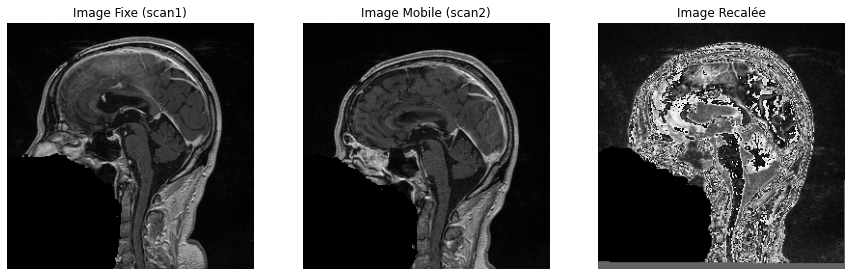

In [6]:
# Convertir les images en tableaux numpy
img1 = itk.GetArrayFromImage(fixed_image)
img2 = itk.GetArrayFromImage(moving_image)
aligned_img = itk.GetArrayFromImage(caster.GetOutput())

slice_index = img1.shape[0] // 2

# Visualiser les images avant et après le recalage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img1[slice_index, :, :], cmap='gray')
axes[0].set_title('Image Fixe (scan1)')
axes[0].axis('off')

axes[1].imshow(img2[slice_index, :, :], cmap='gray')
axes[1].set_title('Image Mobile (scan2)')
axes[1].axis('off')

axes[2].imshow(aligned_img[slice_index, :, :], cmap='gray')
axes[2].set_title('Image Recalée')
axes[2].axis('off')

plt.show()